# Assignment 4: Finite-Time Optimal Control (Solution)

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

***

These notes were developed by Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display (post/upload) (Links to an external site.) lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Links to an external site.Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.



***

In [ ]:
# Please run this cell only if you are using Google Colab.

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install ttictoc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.2 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected pac

# <font color=blue> 1. Finite-Time Optimal Control of a Vehicle </font>

This question is about solving a nonlinear finit-time optimal control problem and it is similar to the unicycle example discussed in class. For each part of the question, please print out 4 subplots (one for each state vs time). Also print a simple plot showing the vehicle motion ($x_k$ vs $y_k$). In addition, plot 2 subplots (one for each control input vs time). Also, turn in the code for both parts (a) and (b), which formulate the optimization problems described below. For both parts, specify IPOPT as the solver in $\texttt{pyomo}$.

Consider the same simplified kinematic bicycle model used in Homework 1.

\begin{eqnarray}
\dot{x} &=& v\cos(\psi+\beta)\nonumber\\
\dot{y} &=& v\sin(\psi+\beta)\nonumber\\
\dot{v} &=& a \nonumber\\
\dot{\psi} &=& \frac{v}{l_r}\sin(\beta)\nonumber\\
\beta &=& \tan^{-1} \left( \frac{l_r}{l_f+l_r} \tan(\delta_f)\right) \nonumber
\end{eqnarray}


where
\begin{align}
x &= \text{ global x CoG coordinate} \nonumber \\
y &= \text{ global y CoG coordinate} \nonumber \\
v &= \text{ speed of the vehicle} \nonumber \\
\psi &= \text{ global heading angle} \nonumber \\
\beta &= \text{ angle of the current velocity with respect to the longitudinal axis of the car} \nonumber \\
a &= \text{ acceleration of the center of mass into this direction} \nonumber \\
l_r &= \text{ distance from the center of mass of the vehicle to the rear axle} \nonumber \\
l_f &= \text{ distance from the center of mass of the vehicle to the front axle} \nonumber \\
\delta_f &= \text{ steering angle of the front wheels with respect to the longitudinal axis of the car} \nonumber
\end{align}

Collect the states in one vector $z = [x, y, v, \psi]^T$, and the inputs as $u = [a, \beta]^T$. Obtain a discrete-time model by using Forward Euler Discretization with sampling time $\Delta t = 0.2$. Use $l_f=l_r = 1.738$ in the simulation. You are asked to formulate and solve a parking problem as a finite-time optimal control problem. The vehicle starts from the initial state $\bar{z}_0 = [\hspace{0.5mm}0, \hspace{1mm}3,\hspace{1mm} 0,\hspace{1mm} 0\hspace{0.5mm}]^T$. Our goal is to park the vehicle in the terminal state $\bar{z}_N=[0,0,0,-\pi/2]^T$. Set the horizon $N = 70$ and the state constraints to be: $[-20, \hspace{2.5mm}-5,\hspace{2.5mm}-10, \hspace{2.5mm}-2\pi]^T \leq z(k) \leq [20, \hspace{2.5mm}10,\hspace{2.5mm}10, \hspace{2.5mm}2\pi]^T $. Solve the finite time optimal control problem and plot the results.

$\textbf{Part (a)}$

Parking Problem Formulation 1

Consider the finite time optimal control problem defined below. Formulate and solve the optimzation problem in $\texttt{pyomo}$.

\begin{align}
\min_{z_0,\ldots,z_N,u_0,\ldots,u_{N-1}} & \sum_{k=N-2}^{N} \|z_k  - \bar{z}_N \|_2^2 \nonumber\\
& z_{k+1} = z_k+f(z_k,u_k)\Delta t &&~\forall k = \left\{0,\ldots,N-1 \right\} \nonumber\\
& z_{min} \leq z_k \leq z_{max} &&~\forall k = \left\{0,\ldots,N \right\} \nonumber\\
& u_{min} \leq u_k \leq u_{max} &&~\forall k = \left\{0,\ldots,N-1 \right\} \nonumber\\
& | \beta_{k+1} - \beta_k | \leq \beta_{d} &&~\forall k = \left\{0,\ldots,N-2 \right\} \nonumber\\
%& |a(k+1) - a(k)| \leq a_d &&~\forall k = \left\{0,\ldots,H_p-1 \right\} \nonumber\\
& z_0 = \bar{z}_0\nonumber\nonumber\\
& z_N = \bar{z}_N\nonumber
\end{align}
Consider the following constraints:

1. The difference of current and previous steering commands are bounded by $\pm 0.2 $ rad. (i.e. $\beta_d = 0.2$)
2. The accelerations are bounded by $|a(k)| \leq 0.3 \ \text{m/s}^2$.
3. The steering control inputs are limited to $|\beta(k)| \leq 0.6$ rad.

In [ ]:
# System parameters and simulation setting
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

# simulation parameters
Ts = 0.2
N = 70
TFinal = Ts*N

# z is state vector, u is input, Ts is sampling period.

z0Bar = np.array([0,3,0,0])
zNBar = np.array([0,0,0,-np.pi/2])
zMax = np.array([20,10,10,2*np.pi])
zMin = np.array([-20,-5,-10,-2*np.pi])

nz = 4        # number of states
nu = 2         # number of inputs

l_r   = 1.738

model = pyo.ConcreteModel()
model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
model.zidx = pyo.Set(initialize=range(0, nz))
model.uidx = pyo.Set(initialize=range(0, nu))

# Create state and input variables trajectory:
model.z = pyo.Var(model.zidx, model.tidx)
model.u = pyo.Var(model.uidx, model.tidx)

# Objective:
model.cost = pyo.Objective(expr = sum((model.z[i, t] - zNBar[i])**2 for i in model.zidx for t in model.tidx if t >= N-2), sense=pyo.minimize)

# Constraints:

model.constraint1 = pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == z0Bar[i])
model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts*(model.z[2, t]*pyo.cos(model.z[3, t] + model.u[1, t]))
                                   if t < N else pyo.Constraint.Skip)
model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts*(model.z[2, t]*pyo.sin(model.z[3, t] + model.u[1, t]))
                                   if t < N else pyo.Constraint.Skip)
model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts*model.u[0, t]
                                   if t < N else pyo.Constraint.Skip)
model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts*(model.z[2, t]/l_r*pyo.sin(model.u[1, t]))
                                   if t < N else pyo.Constraint.Skip)

model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 0.3
                                   if t < N else pyo.Constraint.Skip)
model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= -0.3
                                   if t < N else pyo.Constraint.Skip)

model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] <= 0.2
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] >= -0.2
                                   if t < N-1 else pyo.Constraint.Skip)

model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -0.6
                                   if t < N else pyo.Constraint.Skip)
model.constraint11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 0.6
                                   if t < N else pyo.Constraint.Skip)

model.constraint12 = pyo.Constraint(model.zidx, rule=lambda model, i:model.z[i, N] == zNBar[i])

model.constraint13 = pyo.Constraint(model.zidx, model.tidx, rule=lambda model, i, t: model.z[i, t] <= zMax[i]
                                   if t <= N else pyo.Constraint.Skip)

model.constraint14 = pyo.Constraint(model.zidx, model.tidx, rule=lambda model, i, t: model.z[i, t] >= zMin[i]
                                   if t <= N else pyo.Constraint.Skip)

# Now we can solve:
results = pyo.SolverFactory('ipopt').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1274
  Number of variables: 424
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.7612416744232178
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


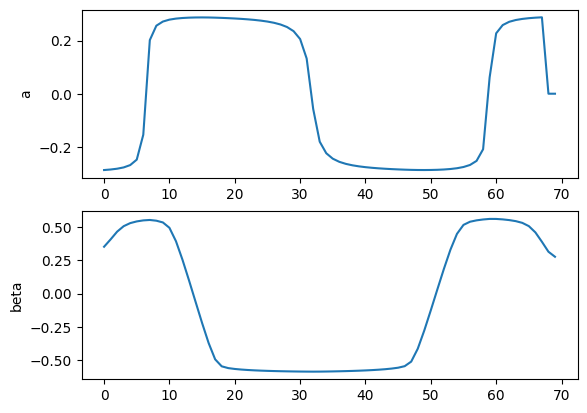

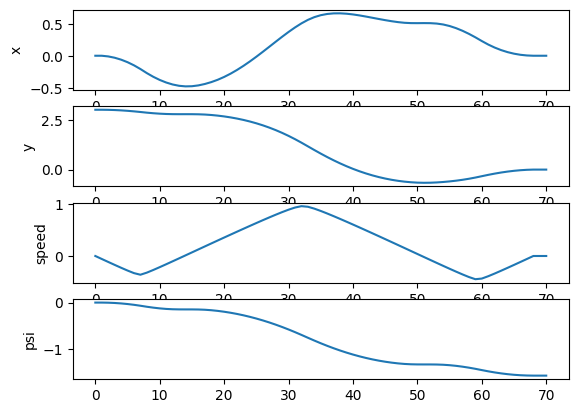

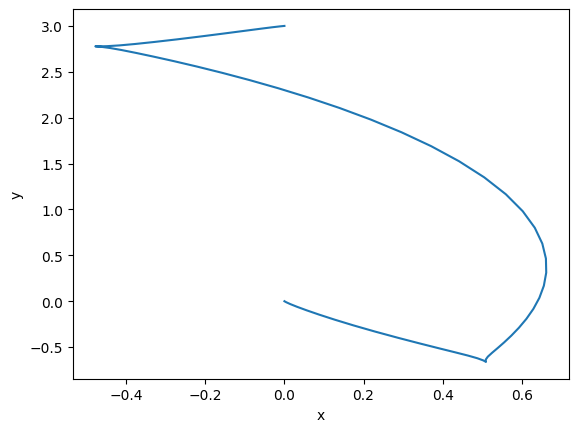

In [ ]:
# plot results
x = [pyo.value(model.z[0,0])]
y = [pyo.value(model.z[1,0])]
v = [pyo.value(model.z[2,0])]
psi = [pyo.value(model.z[3,0])]
a = [pyo.value(model.u[0,0])]
beta = [pyo.value(model.u[1,0])]

for t in model.tidx:
    if t < N:
        x.append(pyo.value(model.z[0,t+1]))
        y.append(pyo.value(model.z[1,t+1]))
        v.append(pyo.value(model.z[2,t+1]))
        psi.append(pyo.value(model.z[3,t+1]))
    if t < N-1:
        a.append(pyo.value(model.u[0,t+1]))
        beta.append(pyo.value(model.u[1,t+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(a)
plt.ylabel('a')
plt.subplot(2,1,2)
plt.plot(beta)
plt.ylabel('beta')

plt.figure()
plt.subplot(4,1,1)
plt.plot(x)
plt.ylabel('x')
plt.subplot(4,1,2)
plt.plot(y)
plt.ylabel('y')
plt.subplot(4,1,3)
plt.plot(v)
plt.ylabel('speed')
plt.subplot(4,1,4)
plt.plot(psi)
plt.ylabel('psi')
plt.show()

plt.figure()
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

$\textbf{Part (b)}$

Parking Problem Formulation 2

Use formulation 1 and add the additional constraints on the difference between current and previous acceleration to get a smoother parking maneuver:

\begin{align}
|a(k+1) - a(k)| \leq a_d \quad \forall k = {0,\ldots,N-2},
\end{align}

where $a_d = 0.06$ m/s$^2$. Formulate the optimzation problem in $\texttt{pyomo}$.

The optimization problem is now infeasible.

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1404
  Number of variables: 424
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  Termination condition: infeasible
  Id: 200
  Error rc: 0
  Time: 1.1219394207000732
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number

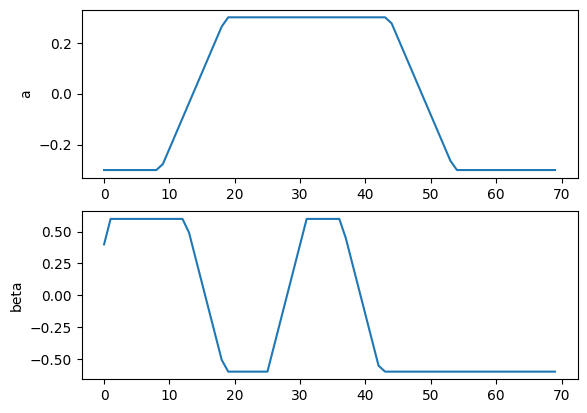

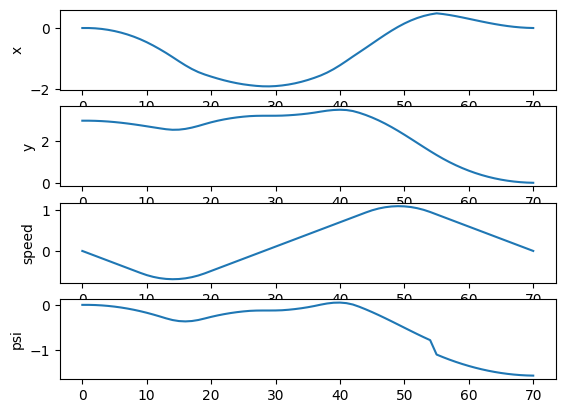

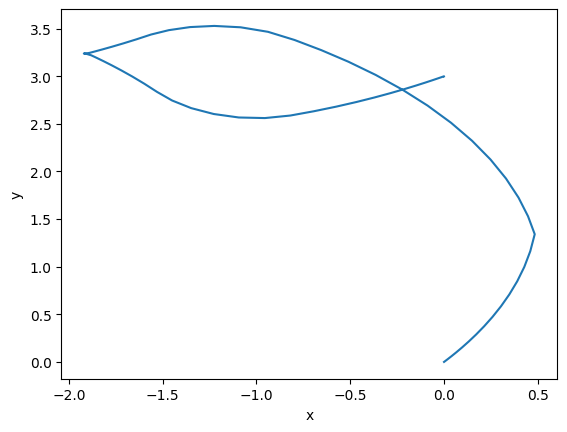

In [ ]:
# simulation parameters
Ts = 0.2
N = 70
TFinal = Ts*N

nz = 4        # number of states
nu = 2         # number of inputs

l_r   = 1.738

z0Bar = np.array([0,3,0,0])
zNBar = np.array([0,0,0,-np.pi/2])
zMax = np.array([20,10,10,2*np.pi])
zMin = np.array([-20,-5,-10,-2*np.pi])

model = pyo.ConcreteModel()
model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
model.zidx = pyo.Set(initialize=range(0, nz))
model.uidx = pyo.Set(initialize=range(0, nu))

# Create state and input variables trajectory:
model.z = pyo.Var(model.zidx, model.tidx)
model.u = pyo.Var(model.uidx, model.tidx)

# Objective:
model.cost = pyo.Objective(expr = sum((model.z[i, t] - zNBar[i])**2 for i in model.zidx for t in model.tidx if t >= N-2), sense=pyo.minimize)

# Constraints:
model.constraint1 = pyo.Constraint(model.zidx, rule=lambda model, i: model.z[i, 0] == z0Bar[i])
model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts*(model.z[2, t]*pyo.cos(model.z[3, t] + model.u[1, t]))
                                   if t < N else pyo.Constraint.Skip)
model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts*(model.z[2, t]*pyo.sin(model.z[3, t] + model.u[1, t]))
                                   if t < N else pyo.Constraint.Skip)
model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts*model.u[0, t]
                                   if t < N else pyo.Constraint.Skip)
model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[3, t+1] == model.z[3, t] + Ts*(model.z[2, t]/l_r*pyo.sin(model.u[1, t]))
                                   if t < N else pyo.Constraint.Skip)
model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 0.3
                                   if t < N else pyo.Constraint.Skip)
model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= -0.3
                                   if t < N else pyo.Constraint.Skip)
model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] <= 0.2
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint9 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t+1] - model.u[1, t] >= -0.2
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint10 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -0.6
                                   if t < N else pyo.Constraint.Skip)
model.constraint11 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 0.6
                                   if t < N else pyo.Constraint.Skip)
model.constraint12 = pyo.Constraint(model.zidx, rule=lambda model, i:model.z[i, N] == zNBar[i])

model.constraint13 = pyo.Constraint(model.zidx, model.tidx, rule=lambda model, i, t: model.z[i, t] <= zMax[i]
                                   if t < N else pyo.Constraint.Skip)

model.constraint14 = pyo.Constraint(model.zidx, model.tidx, rule=lambda model, i, t: model.z[i, t] >= zMin[i]
                                   if t < N else pyo.Constraint.Skip)
model.constraint15 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] >= -0.06
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint16 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t+1] - model.u[0, t] <= 0.06
                                   if t < N-1 else pyo.Constraint.Skip)

# Now we can solve:
results = pyo.SolverFactory('ipopt').solve(model).write()


# plot results
x = [pyo.value(model.z[0,0])]
y = [pyo.value(model.z[1,0])]
v = [pyo.value(model.z[2,0])]
psi = [pyo.value(model.z[3,0])]
a = [pyo.value(model.u[0,0])]
beta = [pyo.value(model.u[1,0])]

for t in model.tidx:
    if t < N:
        x.append(pyo.value(model.z[0,t+1]))
        y.append(pyo.value(model.z[1,t+1]))
        v.append(pyo.value(model.z[2,t+1]))
        psi.append(pyo.value(model.z[3,t+1]))
    if t < N-1:
        a.append(pyo.value(model.u[0,t+1]))
        beta.append(pyo.value(model.u[1,t+1]))

plt.figure()
plt.subplot(2,1,1)
plt.plot(a)
plt.ylabel('a')
plt.subplot(2,1,2)
plt.plot(beta)
plt.ylabel('beta')

plt.figure()
plt.subplot(4,1,1)
plt.plot(x)
plt.ylabel('x')
plt.subplot(4,1,2)
plt.plot(y)
plt.ylabel('y')
plt.subplot(4,1,3)
plt.plot(v)
plt.ylabel('speed')
plt.subplot(4,1,4)
plt.plot(psi)
plt.ylabel('psi')
plt.show()

plt.figure()
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

***

# <font color = blue> 2. Unconstrained Linear Finite Time Optimal Control - Batch </font>

Consider the discrete-time dynamic system with the following state space representation:

\begin{align}
 \label{eq:Dyn_Sys}
    \begin{bmatrix}
      x_1(k+1) \\
      x_2(k+1) \end{bmatrix} = \begin{bmatrix}
      0.77 & -0.35 \\
      0.49 & 0.91
    \end{bmatrix}
    \begin{bmatrix}
      x_1 (k) \\
      x_2 (k)
    \end{bmatrix} + \begin{bmatrix}
      0.04 \\
      0.15
    \end{bmatrix} u(k)
\end{align}

We want to design a linear quadratic optimal control for this system with a finite horizon $N = 50$. We set the following cost matrices:

\begin{align}
Q = \left[ \begin{matrix}
500 & 0 \\ 0 & 100  \end{matrix} \right],  \ \ R = 1, \ \
P = \left[ \begin{matrix}
1500 & 0 \\
0 & 100
\end{matrix} \right],
\end{align}
and assume that the initial state is $x(0) = [ 1, -1]^T$;

$\textbf{Part (a)}$

Determine the optimal  set of inputs
\begin{align}
U_0= \left[\begin{matrix}
u_0 \\ u_1 \\ \vdots \\ u_{N-1} \\
\end{matrix}\right]
\end{align}

through the Batch Approach, i.e. by writing the dynamic equations as follows:
\begin{align*}
\left[ \begin{array}{c} x_0 \\ x_1 \\ \vdots \\ \vdots \\ x_N \end{array} \right] & = \left[ \begin{array}{c} I \\ A \\ \vdots \\ \vdots \\ A^N \end{array} \right] x(0)+ \left[ \begin{array}{cccc} 0 & \cdots & \cdots & 0 \\ B & 0 & \cdots & 0 \\ AB & B & \cdots & 0 \\ \vdots & \ddots & \ddots & 0 \\ A^{N-1}B & \cdots & AB & B \end{array} \right] \left[ \begin{array}{c} u_0 \\ u_1 \\ \vdots \\ \vdots \\ u_{N-1} \end{array} \right] \\ & = \mathcal{S}^x x(0) + \mathcal{S}^u U_0,
\end{align*}
and using the formula:
\begin{align*}
U_0^*(x(0)) & = - (\mathcal{S}^{uT}\overline{Q}\mathcal{S}^u + \overline{R})^{-1}\mathcal{S}^{uT}\overline{Q}\mathcal{S}^x x(0)  \, ,
\end{align*}
and calculate the optimal cost $J_0^*(x(0))$:
\begin{align*}
J_0^*(x(0)) & = x(0)^T(\mathcal{S}^{xT}\overline{Q}\mathcal{S}^x - \mathcal{S}^{xT}\overline{Q}\mathcal{S}^u(\mathcal{S}^{uT}\overline{Q}\mathcal{S}^u + \overline{R})^{-1}\mathcal{S}^{uT}\overline{Q}\mathcal{S}^x)x(0)\, .
\end{align*}

In [ ]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
from numpy.linalg import inv


def Sx_Su(A, B, N):

    nX = np.size(A,0)
    nU = np.size(B,1)

    Sx = np.eye(nX)
    A_tmp = A
    for i in range(N):
        Sx = np.vstack((Sx, A_tmp))
        A_tmp = A_tmp @ A

    SxB = Sx @ B
    Su = np.zeros((nX*(N+1),nU*N))

    for j in range(N):
        Su_tmp = np.vstack((np.zeros((nX, nU)), SxB[:-nX,:]))
        Su[:, j] = Su_tmp.reshape(Su_tmp.shape[0], )
        SxB = Su_tmp

    return Sx, Su

def lqrBatch(A,B,Q,R,PN,N):
    Sx, Su = Sx_Su(A, B, N)
    Qbar  = sp.linalg.block_diag(np.kron(np.eye(N),Q),PN)
    Rbar = np.kron(np.eye(N),R)
    QSu = Qbar@Su
    H = Su.T@QSu+Rbar
    F = Sx.T@QSu
    K = -np.linalg.inv(H)@F.T
    P0 = F@K + Sx.T @Qbar@Sx
    return K,P0
# Solve the finite-horizon, LQR problem for a time-invariant discrete-time
# system.  A is nX-by-nX, B is nX-by-nU, (Q,R,PN) are symmetric and positive
# semidefinite (R positive-definite), and of dimension nX-by-nX, nU-by-nU,
# and nX-by-nX, respectively.   N denotes the number of time-steps.  The
# output argument K is N*nU-by-nX, so that K*x0 is the (vertically
# concatenated) sequence of optimal inputs, {u_0, u_1, ..., u_{N-1}}.  The
# optimal cost, from any initial condition x0, is x0'*P0*x0.

A = np.array([[0.77, -0.35],
              [0.49, 0.91]])
B = np.array([[0.04],
              [0.15]])
Q = np.diag((500,100))
R = 1
PN = np.diag((1500,100))
# x0 = np.array([[1],[-1]])
x0 = np.array([1,-1])
N = 50

K,P0 = lqrBatch(A,B,Q,R,PN,N)
U0_star = K@x0
J0_star = x0.T@P0@x0

print('K= ', K)
print('P0= ',P0)
print('U0_star = ',U0_star)
print('J0_star = ',J0_star)


K=  [[-2.04606782e+00 -6.12786516e+00]
 [-2.52996625e+00  1.27389726e+00]
 [-1.50777708e+00  1.49392578e+00]
 [-7.64065175e-01  8.83586265e-01]
 [-3.64021361e-01  4.46595224e-01]
 [-1.68736910e-01  2.12534786e-01]
 [-7.72045769e-02  9.84667784e-02]
 [-3.51006267e-02  4.50416686e-02]
 [-1.59080807e-02  2.04754233e-02]
 [-7.19841996e-03  9.27917145e-03]
 [-3.25472325e-03  4.19870417e-03]
 [-1.47102150e-03  1.89839019e-03]
 [-6.64718235e-04  8.57999591e-04]
 [-3.00339700e-04  3.87707288e-04]
 [-1.35695693e-04  1.75177477e-04]
 [-6.13067658e-05  7.91463992e-05]
 [-2.76977971e-05  3.57580058e-05]
 [-1.25135138e-05  1.61551132e-05]
 [-5.65342883e-06  7.29867454e-06]
 [-2.55413517e-06  3.29743788e-06]
 [-1.15391941e-06  1.48973342e-06]
 [-5.21323015e-07  6.73038874e-07]
 [-2.35525649e-07  3.04068600e-07]
 [-1.06406829e-07  1.37373468e-07]
 [-4.80729556e-08  6.20632067e-08]
 [-2.17186115e-08  2.80391920e-08]
 [-9.81212306e-09  1.26676642e-08]
 [-4.43296976e-09  5.72305624e-09]
 [-2.00274627e-0

Print out $U_0^*(x(0))^T$ and $J_0^*(x(0))$.
*Hint:* To efficiently concatenate the matrices use $\texttt{scipy.linalg.block_diag}$ and $\texttt{numpy.kron}$.

$\textbf{Part (b)}$

Verify the results of the previous point by solving a numerical optimization problem.
In fact, the cost can be written as a function of  $U_0$  as follows:

\begin{align*}
J_0(x(0),U_0) & = (\mathcal{S}^x x(0) + \mathcal{S}^u U_0)^T\overline{Q}(\mathcal{S}^x x(0) + \mathcal{S}^u U_0) + U_0^T\overline{R}U_0 \\
    & = U_0^T H U_0 + 2 x(0)^TFU_0 + x(0)^T \mathcal{S}^{xT}\overline{Q}\mathcal{S}^x x(0),
\end{align*}

where $H := \mathcal{S}^{uT}\overline{Q}\mathcal{S}^u + \overline{R}$ and $F := \mathcal{S}^{xT}\overline{Q}\mathcal{S}^u$,
and then minimized by solving an quadratic minimization problem.
Check that the optimizer $U_0^*$ and the optimum $J_0(x(0),U_0^*)$ correspond to the ones determined analytically in the previous point.

*Note:* Make sure you compute the unconstrained solution here and do not have any linear constraints.

In [ ]:
# use cvxopt to solve quadratic program
# H and F are given and no constraint is included
import cvxopt
from cvxopt import matrix, solvers

Qbar  = sp.linalg.block_diag(np.kron(np.eye(N),Q),PN)
Rbar = np.kron(np.eye(N),R)
Sx, Su = Sx_Su(A, B, N)
QSu = Qbar@Su
H = Su.T@QSu+Rbar
F = Sx.T@QSu

P = 2*H
q = 2*x0.T@F

P = cvxopt.matrix(P, tc='d')
q = cvxopt.matrix(q.T, tc='d')
sol = cvxopt.solvers.qp(P,q)

print('U0_star =', sol['x'])
print('J0_star =', sol['primal objective'] + x0.T@(Sx.T @Qbar@Sx)@x0)

U0_star = [ 4.08e+00]
[-3.80e+00]
[-3.00e+00]
[-1.65e+00]
[-8.11e-01]
[-3.81e-01]
[-1.76e-01]
[-8.01e-02]
[-3.64e-02]
[-1.65e-02]
[-7.45e-03]
[-3.37e-03]
[-1.52e-03]
[-6.88e-04]
[-3.11e-04]
[-1.40e-04]
[-6.35e-05]
[-2.87e-05]
[-1.30e-05]
[-5.85e-06]
[-2.64e-06]
[-1.19e-06]
[-5.40e-07]
[-2.44e-07]
[-1.10e-07]
[-4.98e-08]
[-2.25e-08]
[-1.02e-08]
[-4.59e-09]
[-2.07e-09]
[-9.37e-10]
[-4.23e-10]
[-1.91e-10]
[-8.64e-11]
[-3.90e-11]
[-1.76e-11]
[-7.96e-12]
[-3.60e-12]
[-1.63e-12]
[-7.33e-13]
[-3.32e-13]
[-1.50e-13]
[-6.87e-14]
[-2.94e-14]
[-1.46e-14]
[-5.84e-15]
[-2.82e-15]
[-1.13e-15]
[-8.11e-16]
[-2.93e-16]

J0_star = 1872.3385566528882


***

# <font color=blue> 3. Constrained Finite Time Optimal Control - Sparse vs Dense QP Formulations </font>

Consider CFTOC of a discrete-time double-integrator system:
\begin{align}
\min_{\substack{ u_0,\dots,u_{N-1} \\ x_1,\dots,x_N }} ~&~ x_N^TPx_N + \displaystyle{\sum}_{k=0}^{N-1}  x_k^TQx_k + u_k^TRu_k \\
\text{subject to} ~&~ x_{k+1}=
\begin{bmatrix} 1 & 1 \\  0 & 1 \end{bmatrix}
x_k
+
\begin{bmatrix} 0 \\ 1 \end{bmatrix}
u_k \\
& -1 \leq u_k \leq 1, ~k \in \left\{ 0, \ldots, N-1 \right\} \\
& \begin{bmatrix} -15 \\ -15 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 15 \\ 15 \end{bmatrix}, ~k \in \left\{ 1, \ldots, N \right\}
\end{align}
where $N = 3$, $P = Q = \mathcal{I}_{2 \times 2}$, $R = 0.1$.

$\textbf{Part (a)}$

Let  $x_0 = [-1, -1]^T$.
Determine the QP $\textbf{dense}$ formulation when you substitute the dynamics in the CFTOC. That is, determine $H, f, c, A, b$ for the following problem:
\begin{align*}
\min_{U_0} ~&~ \frac{1}{2} U_0^T H U_0 + f^T U_0 + c\\
\text{subject to} ~&~ A U_0 \leq b.
\end{align*}

where $U_0 =\left[ u_0^T, u_1^T, \ldots, u_{N-1}^T \right]^T$. Write the code to synthesize these matrices and then compute the solution using $\texttt{cvxopt}$. Note that you can drop the $c$ term when using $\texttt{cvxopt}$. You should NOT have any $Aeq$ or $beq$. Make sure to turn in your code and outputs (synthesized matrices, solver solution and optimal value). How many $0$'s are in $A$? In $H$?

In [ ]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
from numpy.linalg import inv
import time
from ttictoc import tic,toc

# Define state and controller matricies
nX = 2
nU = 1
Ax = np.array([[1, 1],
               [0, 1]])
Bx = np.array([[0],
              [1]])
Q = np.eye(2)
P = np.eye(2)
R = 0.1
N = 3
x0 = np.array([[-1],[-1]])


# Define state and input constraints
ULlim = -1
UUlim = 1
xLlim = np.array([-15, -15])
xUlim = np.array([15, 15])

Sx, Su = Sx_Su(Ax, Bx, N)

Qbar  = sp.linalg.block_diag(np.kron(np.eye(N),Q),P)
Rbar = np.kron(np.eye(N),R)
QSu = Qbar@Su
H = Su.T@QSu+Rbar
F = Sx.T@QSu
K = -np.linalg.inv(H)@F.T
P0 = F@K + Sx.T @Qbar@Sx

c = x0.T@Sx.T@Qbar@Sx@x0

A = np.concatenate([np.kron(np.array([[1],[-1]]),np.eye(3)), Su, -Su], axis = 0)
b = np.concatenate([np.ones((2*nU*N,1)), 15*np.ones((2*nX*(N+1),1))-np.concatenate([Sx,-Sx], axis = 0)@x0], axis = 0)

P = 2*H
q = 2*x0.T@F

P = cvxopt.matrix(P, tc='d')
q = cvxopt.matrix(q.T, tc='d')
G = cvxopt.matrix(A, tc='d')
h = cvxopt.matrix(b, tc='d')

tic()
sol = cvxopt.solvers.qp(P,q,G,h)
t_dense = toc()
print('Elapsed time:',t_dense)

Uopt_dense = sol['x']
Jopt_dense = sol['primal objective']+c

print('The optimal control sequence=', Uopt_dense)
print('The optimal cost=', Jopt_dense)
print('The H matrix=', H)
print('The F matrix=', F)
print('The c matrix=', c)
print('The A matrix=', A)
print('The b matrix=', b)
print('Number of zeros in A matrix=', np.size(A,0)*np.size(A,1) - np.count_nonzero(A))
print('Number of zeros in H matrix=', np.size(H,0)*np.size(H,1) - np.count_nonzero(H))

     pcost       dcost       gap    pres   dres
 0: -2.4779e+01 -8.2232e+02  1e+03  1e-01  6e-16
 1: -1.9633e+01 -8.5580e+01  7e+01  3e-03  2e-16
 2: -2.0823e+01 -2.6044e+01  5e+00  2e-04  8e-17
 3: -2.1589e+01 -2.2124e+01  5e-01  1e-05  4e-17
 4: -2.1717e+01 -2.1764e+01  5e-02  4e-08  9e-17
 5: -2.1726e+01 -2.1729e+01  4e-03  2e-16  6e-17
 6: -2.1726e+01 -2.1726e+01  5e-05  2e-16  1e-16
 7: -2.1726e+01 -2.1726e+01  5e-07  1e-16  3e-17
Optimal solution found.
Elapsed time: 0.009435109999969882
The optimal control sequence= [ 1.00e+00]
[ 9.13e-01]
[-8.30e-01]

The optimal cost= [[12.27427386]]
The H matrix= [[8.1 4.  1. ]
 [4.  3.1 1. ]
 [1.  1.  1.1]]
The F matrix= [[ 3.  1.  0.]
 [11.  5.  1.]]
The c matrix= [[34.]]
The A matrix= [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  0.]
 [ 2.  1.  0.]
 [ 1.  1.  1.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [-1

$\textbf{Part (b)}$

Let  $x_0 = [-1, -1]^T$.
Determine the QP $\textbf{sparse}$ formulation when you do NOT substitute the dynamics in the CFTOC. That is, what are $H, f, A, b, Aeq, beq$ for the following problem:
\begin{align*}
\min_{z} ~&~ \frac{1}{2} z^T H z + f^T z \\
\text{subject to} ~&~ Az \leq b \\
&~ A_{eq}z = b_{eq}.
\end{align*}

where $z = [x_1^T, \ldots, x_N^T, u_0^T, \ldots, u_{N-1}^T]^T$. This requires using $Aeq$ and $beq$. Again, write a script to synthesize these matrices and compute the solution using $\texttt{cvxopt}$. Make sure to turn in the outputs (synthesized matrices, $\texttt{cvxopt.solvers.qp}$ solution and optimal value).  How many $0$'s are in $A$? In $H$? In $Aeq$?

$\textbf{Part (c)}$

Compare the $\texttt{cvxopt.solvers.qp}$ solver times compare using $\texttt{tic toc}$ commands. Check your solutions to make sure the two methods get the same answer.

In [ ]:
Q = np.eye(2)
P = np.eye(2)
R = 0.1
N = 3
x0 = np.array([[-1],[-1]])

H = sp.linalg.block_diag(np.kron(np.eye(N-1),Q),P,np.kron(np.eye(N),R))

Aeq = np.concatenate([np.concatenate([np.eye(2), np.zeros((2,2)), np.zeros((2,2)), -Bx, np.zeros((2,1)), np.zeros((2,1))], axis = 1),
       np.concatenate([-Ax, np.eye(2), np.zeros((2,2)), np.zeros((2,1)), -Bx, np.zeros((2,1))], axis = 1),
       np.concatenate([np.zeros((2,2)), -Ax, np.eye(2), np.zeros((2,1)), np.zeros((2,1)), -Bx], axis = 1)], axis = 0)

beq = np.concatenate([Ax, np.zeros((2,2)), np.zeros((2,2))], axis = 0)@x0

A = sp.linalg.block_diag(np.kron(np.concatenate([np.eye(2), -np.eye(2)], axis = 0), np.eye(3)), np.kron(np.array([[1], [-1]]), np.eye(3)))
b = np.concatenate([15*np.ones((2*nX*N,1)), np.ones((2*nU*N,1))], axis = 0)

P = 2*H
q = np.zeros((np.size(H,1)))
c = x0.T@Q@x0

P = cvxopt.matrix(P, tc='d')
q = cvxopt.matrix(q, tc='d')
G = cvxopt.matrix(A, tc='d')
h = cvxopt.matrix(b, tc='d')
Aeq = cvxopt.matrix(Aeq, tc='d')
beq = cvxopt.matrix(beq, tc='d')

tic()
sol = cvxopt.solvers.qp(P,q,G,h,Aeq,beq)
t_sparse = toc()

Uopt_sparse = sol['x']
Jopt_sparse = sol['primal objective']+c
Uopt_sparse_array = np.asarray(Uopt_sparse)

print('Uopt_sparse=', sol['x'])
print('Jopt_sparse=', Jopt_sparse)

print('The optimal control sequence=', np.asarray(Uopt_sparse_array[6:]))
print('The optimal cost=', Jopt_sparse)
print('The H matrix=', H)
print('The F matrix=', q)
print('The A matrix=', A)
print('The b matrix=', b)
print('Number of zeros in A matrix=', np.size(A,0)*np.size(A,1) - np.count_nonzero(A))
print('Number of zeros in H matrix=', np.size(H,0)*np.size(H,1) - np.count_nonzero(H))

print('time to solve the dense formulation=', t_dense)
print('time to solve the sparse formulation=', t_sparse)

<class 'numpy.float64'>
     pcost       dcost       gap    pres   dres
 0:  7.2214e+00 -6.1432e+02  9e+02  1e-01  5e-15
 1:  1.2377e+01 -4.7259e+01  6e+01  3e-03  8e-15
 2:  1.1177e+01  6.4328e+00  5e+00  2e-04  1e-15
 3:  1.0410e+01  9.9089e+00  5e-01  1e-05  5e-15
 4:  1.0283e+01  1.0237e+01  5e-02  2e-08  9e-16
 5:  1.0274e+01  1.0271e+01  3e-03  2e-16  2e-15
 6:  1.0274e+01  1.0274e+01  5e-05  2e-16  2e-15
 7:  1.0274e+01  1.0274e+01  5e-07  2e-16  2e-15
Optimal solution found.
Uopt_sparse= [-2.00e+00]
[-4.11e-10]
[-2.00e+00]
[ 9.13e-01]
[-1.09e+00]
[ 8.30e-02]
[ 1.00e+00]
[ 9.13e-01]
[-8.30e-01]

Jopt_sparse= [[12.27427386]]
The optimal control sequence= [[ 1.        ]
 [ 0.91286202]
 [-0.82987426]]
The optimal cost= [[12.27427386]]
The H matrix= [[1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0